# Exploring the Impact of Parameter Tuning in LSTM Models: a Case Study on Sine Wave Prediction

## Overview

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to handle sequential data by **retaining relevant historical information** while filtering out unnecessary details. Unlike traditional neural networks, which process data in a feedforward manner, RNNs utilize feedback connections, allowing them to incorporate past outputs as inputs for future predictions. However, standard RNNs struggle with long-term dependencies due to issues like vanishing gradients. LSTMs address this problem by introducing a gating mechanism that controls which information to keep, update, or discard, enabling more efficient learning from past data.

This project explores how different hyperparameters influence the performance of an LSTM model in forecasting values of a simple sine wave. By systematically adjusting parameters such as activation functions, the number of LSTM units, and model depth, the aim is to assess their impact on prediction accuracy and overall model performance.

## List of contents

1. Data Generation – Creating a sine wave dataset for training and evaluation.

2. Model Training and Evaluation – Implementing an LSTM model, tuning its parameters, and assessing its performance.

3. Forecasting – Using the trained model to predict future values of the sine wave and analyzing the results.



### 1. Generate the sine wave data

In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data

x = np.arange(0, 100, 0.1)
y = np.sin(x)

Scaling data helps the LSTM model to converge, so let's do that now.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

Now the data needs to be aranged in a certain format (a sequence) used by this kind of learning models. Now let's call a separate module to do the work

In [4]:
from sequence import create_sequences

In this step, we define the **number of past points** to create the sequence. Let's pick 50 past points. 

In [5]:
seq_length = 50  # Number of time steps to look back

X, y = create_sequences(y_scaled, seq_length)

Split the data into training and test sets

In [6]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Finally, let's make sure the data has the correct shape to be feed to the model

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### 2. Model training, model evaluation and forecasting

Again, the model building and training will be done calling a separate previously-made module

In [8]:
from LSTMmodel import build_and_train_lstm

In [9]:
model, summary = build_and_train_lstm(X_train, y_train)

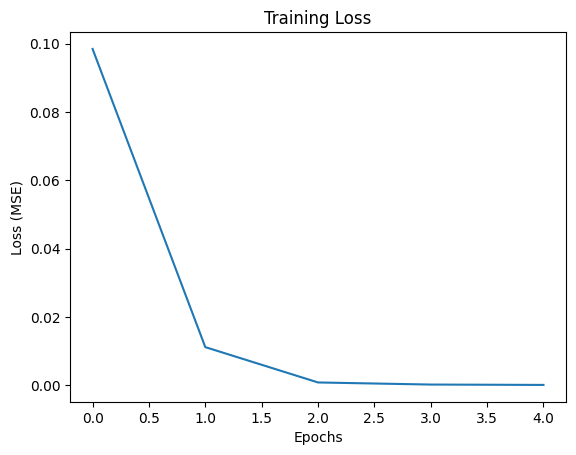

In [10]:
# Extract loss values
loss_values = summary.history['loss']

# Plot training loss over epochs
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()


In [11]:
# Make predictions on the test set

predictions_scaled = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


In [12]:
# Inverse transform the predictions and true values to get them back to original scale

predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

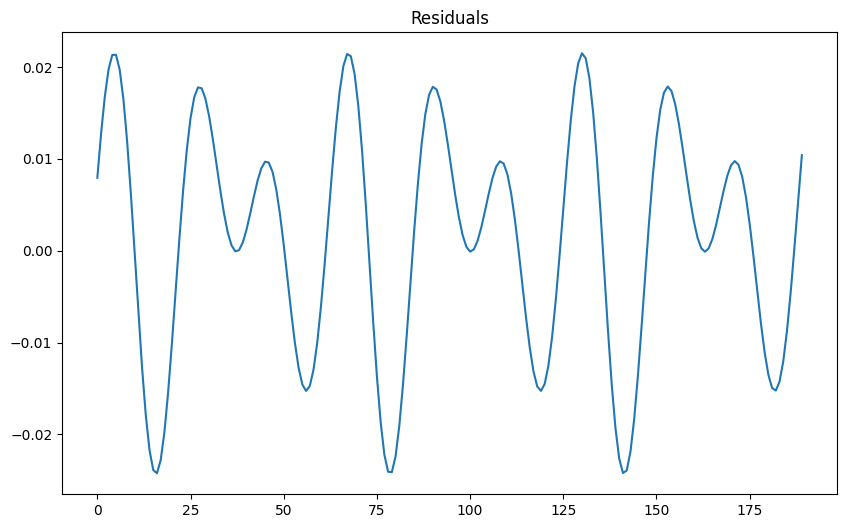

In [13]:
# Calculate residuals
residuals = y_test_actual - predictions

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

From this plot it is clear to see that even though the errors are small, the residues have a repeating pattern, which indicates that the model does not fully capture the underlying data structure, but is consistently under and overfitting the data at regular intervals.

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [15]:
loss_model_0 = model.evaluate(X_test, y_test, verbose=0)
mae_model_0 = mean_absolute_error(y_test, model.predict(X_test))
r2_model_0 = r2_score(y_test, model.predict(X_test))

print(f'Loss: {loss_model_0[0]:.5f}')
print(f'R² Score: {r2_model_0:.5f}')
print(f'MAE: {mae_model_0:.5f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Loss: 0.00004
R² Score: 0.99968
MAE: 0.00528


In [16]:
import pandas as pd

# Model performance metrics
metrics = {
    "Metric": ["Loss", "MAE", "R² Score", "Description"],
    "Base Model": [loss_model_0[0], mae_model_0, r2_model_0, "Base Model"],
}

# Create DataFrame
df = pd.DataFrame(metrics)

df

,Metric,Base Model
0,Loss,0.000039
1,MAE,0.005279
2,R² Score,0.999684
3,Description,Base Model


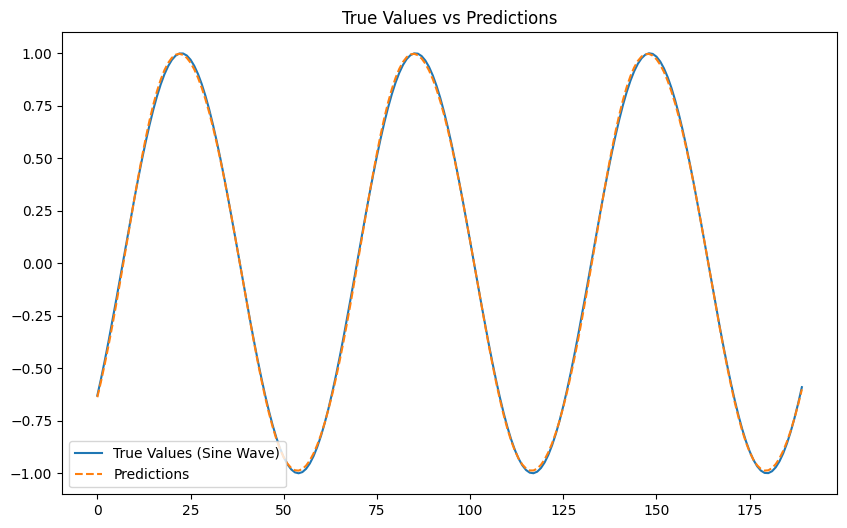

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='True Values (Sine Wave)')
plt.plot(predictions, label='Predictions', linestyle='--')
plt.legend()
plt.title('True Values vs Predictions')
plt.show()


### Tunning model's parameters

#### Activation function

An activation function is a function that calculates the output of a node based on its inputs and their corresponding weights. Most commonly, activation fucntion are non-linear functions.

Different activation fucntions have different mathematical properties, and choosing an appropiate function depends on the task at hand as well. Aside from being linear or non linear functions other things to consider are the function's range, and if they are continious or differentiable functions.

An LSTM consists of a **cell state** (this is the long-term memory part) in which the long-term dependencies are stored and the **gates**, which regulate the information flow (this is the short-term control mechanism). Each gate in turn consist of a *forget gate* (decides which part of the current state should be discarded), an *input gate* (which part of the state should be updated) an a *output gate* which controls the hidden state output.

The activation function specified in the code controls the cell state. The LSTM gates always use sigmoid by default in Keras.

In this regard, the default setup (tanh for activations, sigmoid for gates) is already a good option for sine wave forecasting.

What would happen if instead of a bound function like tanh I choose reLU as activation function?

<ins>model 1</ins>: choose reLU as activation function for the cell state update

In [18]:
model_1, summary_1 = build_and_train_lstm(X_train, y_train, activation='relu')

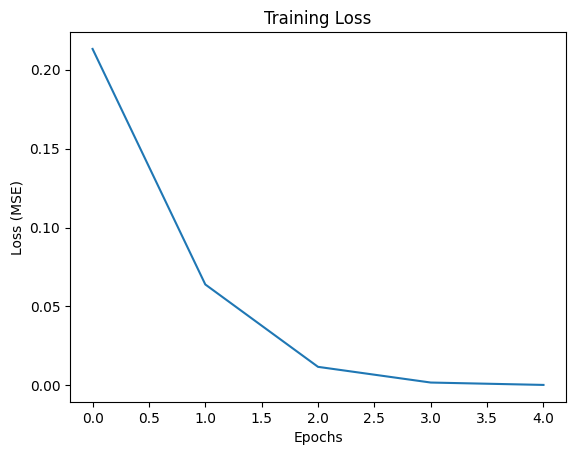

In [19]:
# Extract loss values
loss_values_1 = summary_1.history['loss']

# Plot training loss over epochs
plt.plot(loss_values_1)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.show()

In [20]:
# Make predictions on the test set

predictions_scaled = model_1.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [21]:
# Inverse transform the predictions and true values to get them back to original scale

predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
loss_model_1 = model_1.evaluate(X_test, y_test, verbose=0)
print(loss_model_1[0])

0.00016901669732760638


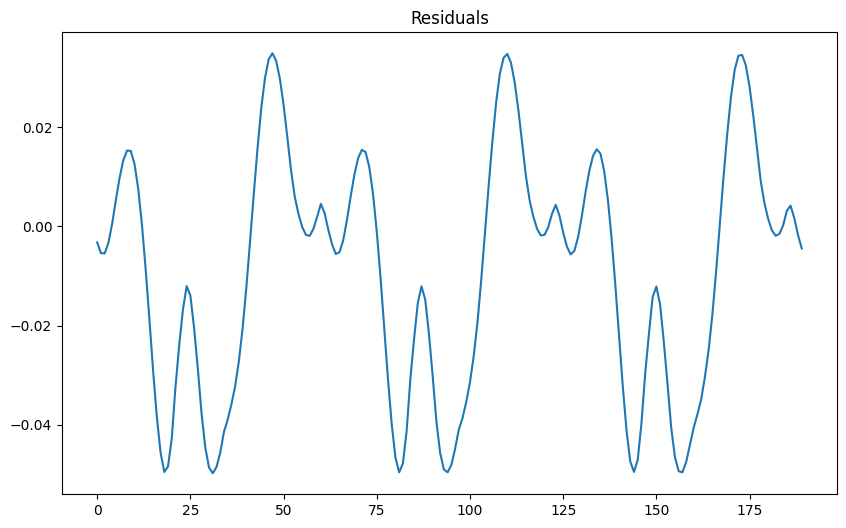

In [23]:
# Calculate residuals
residuals = y_test_actual - predictions

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [24]:
mae_model_1 = mean_absolute_error(y_test, model_1.predict(X_test))
r2_model_1 = r2_score(y_test, model_1.predict(X_test))

print(f'R² Score: {r2_model_1:.5f}')
print(f'MAE: {mae_model_1:.5f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
R² Score: 0.99865
MAE: 0.01025


In [ ]:
# Calculate percentage improvement
# For R², higher is better, so we use (new - old) / old * 100
# For MAE, lower is better, so we use (old - new) / old * 100
#df["Improvement (%)"] = [
#    ((df.loc[0, "Model 1"] - df.loc[0, "Model 0"]) / df.loc[0, "Model 0"]) * 100,  # R² Score
#    ((df.loc[1, "Model 0"] - df.loc[1, "Model 1"]) / df.loc[1, "Model 0"]) * 100,  # MAE
#]

# Display DataFrame
#print(df)

In [25]:
# Model performance metrics
metrics_1 = {
    #"Metric": ["Loss", "MAE", "R² Score", "Description"],
    "Model 1": [loss_model_1[0], mae_model_1, r2_model_1, "reLu activation function"],
}

# Create DataFrame
df_1 = pd.DataFrame(metrics_1)

df_1

,Model 1
0,0.000169
1,0.010254
2,0.998645
3,reLu activation function


In [26]:
df_metrics = pd.concat([df, df_1], axis=1)
df_metrics

,Metric,Base Model,Model 1
0,Loss,0.000039,0.000169
1,MAE,0.005279,0.010254
2,R² Score,0.999684,0.998645
3,Description,Base Model,reLu activation function


### Sequence length

Changing the number of points used to construct the sequence may affect the model's performance: too few points and the model is unable to learn meaningfull patterns of the past, but too many, and the model may start picking up 'useless' information, maybe start learning from 'noise' instead of the real underlying structure in the data, causing the model to overfit.

In [27]:
seq_lengths = [20, 100, 200]

In [28]:
X_seq = {}
y_seq = {}

for seq in seq_lengths:
    X, y = create_sequences(y_scaled, seq)
    X_seq[seq] = X
    y_seq[seq] = y


In [29]:
train_size_ratio = 0.8  # Define train-test split ratio

X_train_seq = {}
X_test_seq = {}
y_train_seq = {}
y_test_seq = {}

for seq in seq_lengths:
    X, y = X_seq[seq], y_seq[seq]  # Retrieve sequences for the given length
    
    train_size = int(len(X) * train_size_ratio)  # Compute train size

    # Split data into train and test sets
    X_train_seq[seq], X_test_seq[seq] = X[:train_size], X[train_size:]
    y_train_seq[seq], y_test_seq[seq] = y[:train_size], y[train_size:]

    # Reshape X_train and X_test for LSTM input (samples, timesteps, features)
    X_train_seq[seq] = X_train_seq[seq].reshape((X_train_seq[seq].shape[0], X_train_seq[seq].shape[1], 1))
    X_test_seq[seq] = X_test_seq[seq].reshape((X_test_seq[seq].shape[0], X_test_seq[seq].shape[1], 1))

    # Print shape to verify correctness
    print(f"Seq {seq}: X_train {X_train_seq[seq].shape}, X_test {X_test_seq[seq].shape}, y_train {y_train_seq[seq].shape}, y_test {y_test_seq[seq].shape}")


Seq 20: X_train (784, 20, 1), X_test (196, 20, 1), y_train (784, 1), y_test (196, 1)
Seq 100: X_train (720, 100, 1), X_test (180, 100, 1), y_train (720, 1), y_test (180, 1)
Seq 200: X_train (640, 200, 1), X_test (160, 200, 1), y_train (640, 1), y_test (160, 1)


In [30]:
models = {}      
summaries = {}   

for seq in seq_lengths:
    model, summary = build_and_train_lstm(X_train_seq[seq], y_train_seq[seq])
    
    models[seq] = model
    summaries[seq] = summary



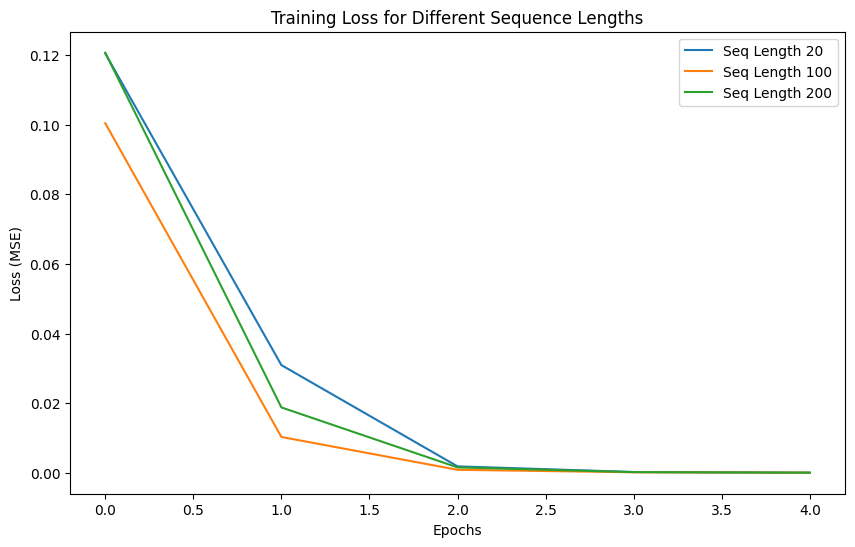

In [31]:
# Plot training loss for each sequence length
plt.figure(figsize=(10, 6))

for seq in seq_lengths:
    loss_values = summaries[seq].history['loss']
    plt.plot(loss_values, label=f'Seq Length {seq}')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Different Sequence Lengths')
plt.legend()
plt.show()

In [32]:
# Make predictions on the test set

predictions_scaled = {}

for seq in seq_lengths:
    predictions_scaled[seq] = models[seq].predict(X_test_seq[seq])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [33]:
# Inverse transform the predictions and true values to get them back to original scale

predictions = {}
y_test_actual = {}

for seq in seq_lengths:
    predictions[seq] = scaler.inverse_transform(predictions_scaled[seq])
    y_test_actual[seq] = scaler.inverse_transform(y_test_seq[seq].reshape(-1, 1))

In [34]:
for seq in seq_lengths:
    print(f"Sequence Length {seq}: X_test shape = {X_test_seq[seq].shape}, y_test shape = {y_test_seq[seq].shape}")


Sequence Length 20: X_test shape = (196, 20, 1), y_test shape = (196, 1)
Sequence Length 100: X_test shape = (180, 100, 1), y_test shape = (180, 1)
Sequence Length 200: X_test shape = (160, 200, 1), y_test shape = (160, 1)


In [35]:
loss_model = {}

for seq in seq_lengths:
    loss_model[seq] = models[seq].evaluate(X_test_seq[seq], y_test_seq[seq], verbose=0)


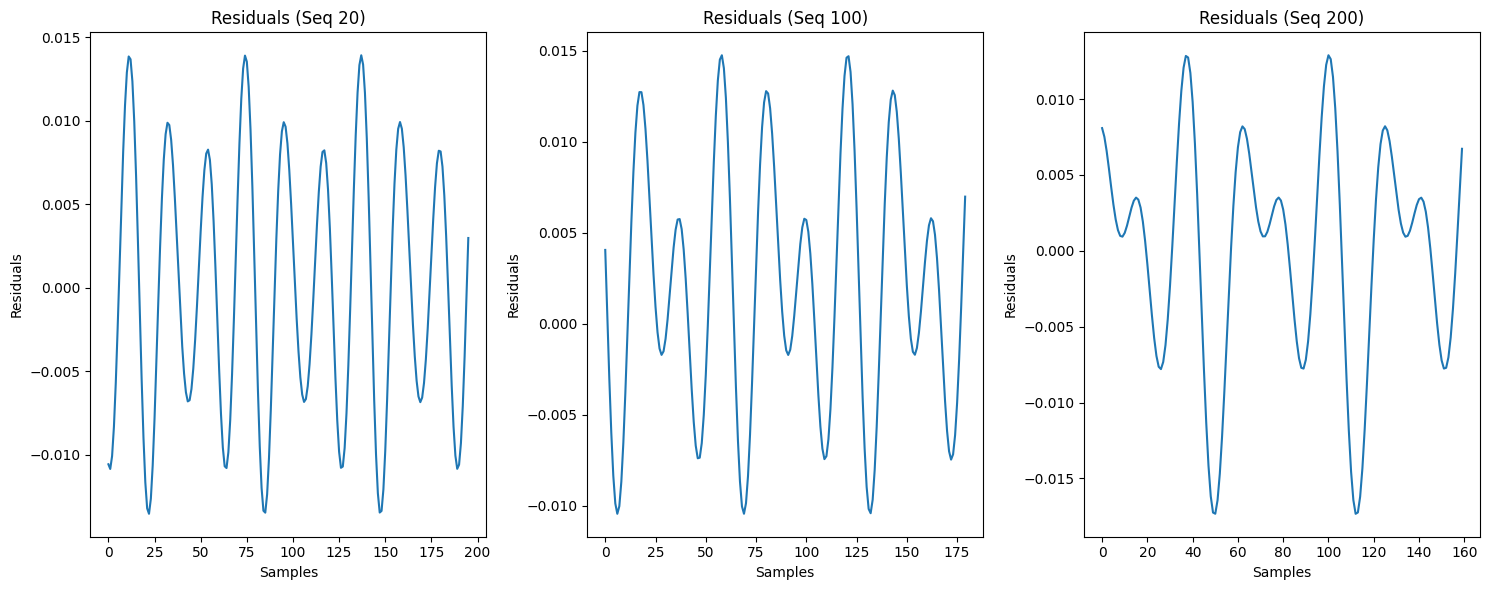

In [36]:
# Calculate residuals for each sequence length
residuals = {}
for seq in seq_lengths:
    residuals[seq] = y_test_seq[seq] - predictions_scaled[seq]

# Create subplots for each sequence length
fig, axes = plt.subplots(1, len(seq_lengths), figsize=(15, 6))  # 1 row, len(seq_lengths) columns

# Plot residuals for each sequence length
for i, seq in enumerate(seq_lengths):
    axes[i].plot(residuals[seq])
    axes[i].set_title(f'Residuals (Seq {seq})')
    axes[i].set_xlabel('Samples')
    axes[i].set_ylabel('Residuals')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [37]:
mae_model_seq = {}
r2_model_seq = {}

for seq in seq_lengths:
    mae_model_seq[seq] = mean_absolute_error(y_test_seq[seq], models[seq].predict(X_test_seq[seq]))
    r2_model_seq[seq] = r2_score(y_test_seq[seq], models[seq].predict(X_test_seq[seq]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Create dictionary for model performance metrics

metrics_seq = {}

# Add model-specific metrics to the dictionary
for seq in seq_lengths:
    metrics_seq[f"Model {seq}"] = [
        loss_model[seq][0],  # Assuming loss_model stores the loss values in position 0
        mae_model_seq[seq],  # Mean Absolute Error for this model
        r2_model_seq[seq],   # R² Score for this model
        f"Sequence built with {seq} points"  # Description (you can customize this)
    ]

# Create DataFrame for model performance metrics
df_seq = pd.DataFrame(metrics_seq)

df_seq.columns = ['Model 2', 'Model 3', 'Model 4']

df_metrics = pd.concat([df_metrics, df_seq], axis=1)
df_metrics

,Metric,Base Model,Model 1,Model 2,Model 3,Model 4
0,Loss,0.000039,0.000169,0.000059,0.000051,0.000053
1,MAE,0.005279,0.010254,0.006747,0.005888,0.005802
2,R² Score,0.999684,0.998645,0.999529,0.999609,0.99957
3,Description,Base Model,reLu activation function,"Sequence built with, 20, points","Sequence built with, 100, points","Sequence built with, 200, points"


#### Number of units

Because there was no difference, I will still go with seq_len = 50

In [39]:
X, y = create_sequences(y_scaled, seq_length)

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [40]:
unit_combinations = [(256, 128), (128, 64)]
models_unit = {}


for units1, units2 in unit_combinations:
    model, summary = build_and_train_lstm(X_train, y_train, units1=units1, units2=units2)
    models_unit[(units1, units2)] = {'model': model, 'summary': summary}
    print(f"Trained model with units1={units1} and units2={units2}")

    


Trained model with units1=256 and units2=128
Trained model with units1=128 and units2=64


In [41]:
model_5 = models_unit[(256, 128)]['model']
model_6 = models_unit[(128, 64)]['model']

summary_5 = models_unit[(256, 128)]['summary']
summary_6 = models_unit[(128, 64)]['summary']

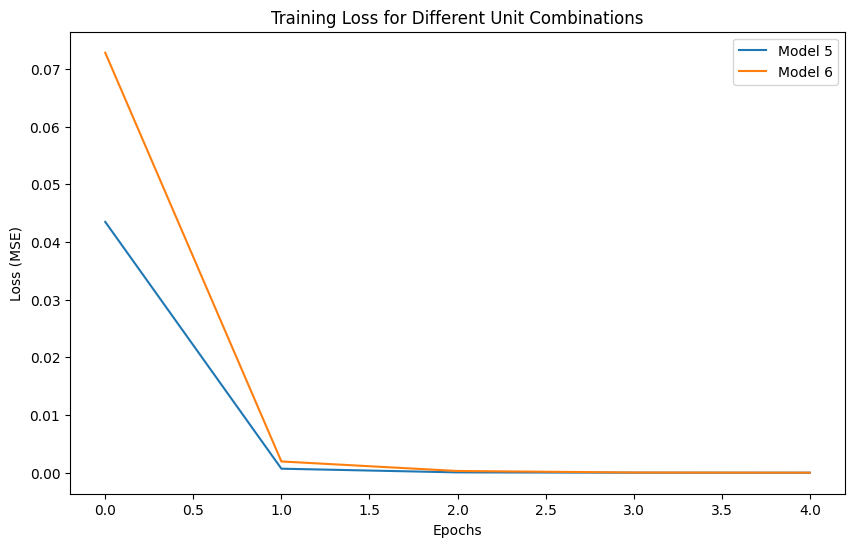

In [42]:
# Plot training loss for each sequence length
plt.figure(figsize=(10, 6))

loss_values_5 = summary_5.history['loss']
loss_values_6 = summary_6.history['loss']

plt.plot(loss_values_5, label=f'Model 5')
plt.plot(loss_values_6, label=f'Model 6')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Different Unit Combinations')
plt.legend()
plt.show()

In [43]:
# Make predictions on the test set

predictions_scaled_5 = model_5.predict(X_test)
predictions_scaled_6 = model_6.predict(X_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


In [44]:
predictions_5 = scaler.inverse_transform(predictions_scaled_5)
predictions_6 = scaler.inverse_transform(predictions_scaled_6)

y_test_actual_5 = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_actual_6 = scaler.inverse_transform(y_test.reshape(-1, 1))

In [45]:
loss_model_5 = model_5.evaluate(X_test, y_test, verbose=0)
loss_model_6 = model_6.evaluate(X_test, y_test, verbose=0)

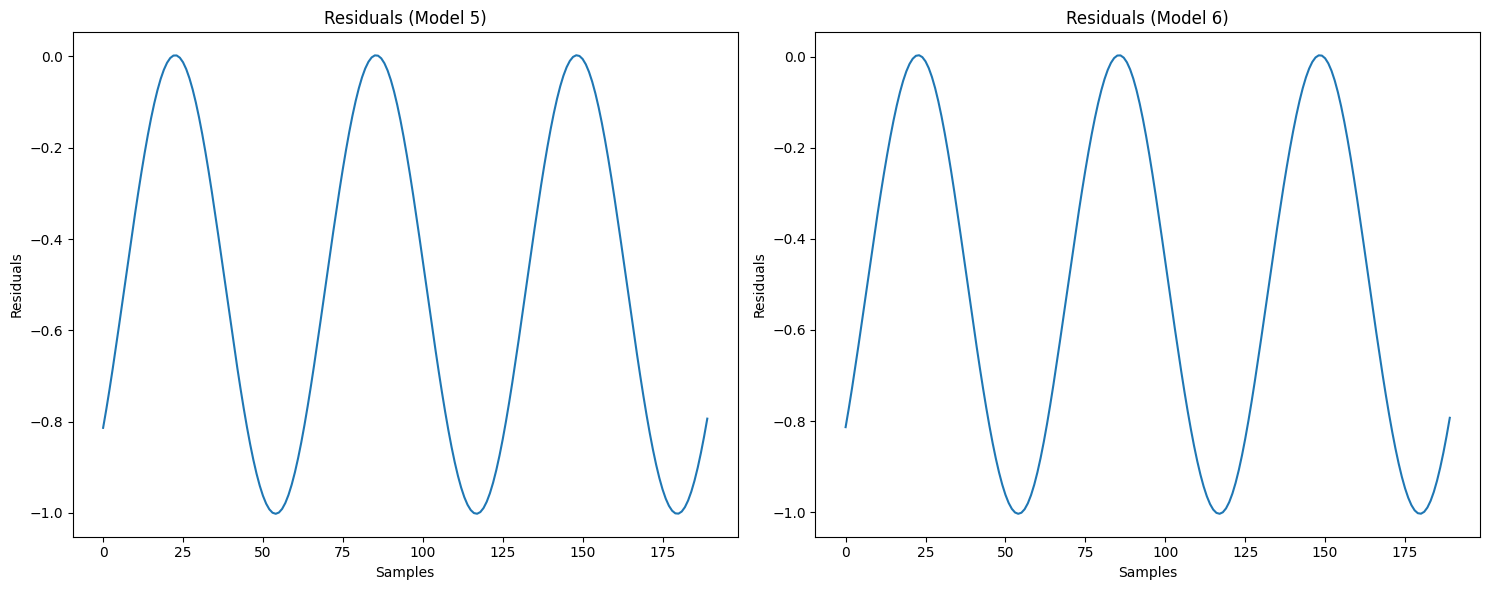

In [46]:
# Calculate residuals for each sequence length

residuals_5 = y_test_actual_5 - predictions_scaled_5
residuals_6 = y_test_actual_6 - predictions_scaled_6

# Create subplots for each sequence length (2 columns, 1 row)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

axes[0].plot(residuals_5)
axes[0].set_title('Residuals (Model 5)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Residuals')

axes[1].plot(residuals_6)
axes[1].set_title('Residuals (Model 6)')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Residuals')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [47]:
mae_model_5 = mean_absolute_error(y_test, model_5.predict(X_test))
mae_model_6 = mean_absolute_error(y_test, model_6.predict(X_test))

r2_model_5 = r2_score(y_test, model_5.predict(X_test))
r2_model_6 = r2_score(y_test, model_6.predict(X_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [48]:
# Create dictionary for model performance metrics

# Create a dictionary with the metrics for each model
metrics_dict = {
    'Model 5': [loss_model_5[0], mae_model_5, r2_model_5, 'unit 1 = 256, unit 2 = 128'],
    'Model 6': [loss_model_6[0], mae_model_6, r2_model_6, 'unit 1 = 128, unit 2 = 64']
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

metrics_df

,Model 5,Model 6
0,0.000002,0.000008
1,0.001144,0.002501
2,0.999986,0.999933
3,"unit 1 = 256, unit 2 = 128","unit 1 = 128, unit 2 = 64"


In [49]:
df_metrics = pd.concat([df_metrics, metrics_df], axis=1)
df_metrics

,Metric,Base Model,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
0,Loss,0.000039,0.000169,0.000059,0.000051,0.000053,0.000002,0.000008
1,MAE,0.005279,0.010254,0.006747,0.005888,0.005802,0.001144,0.002501
2,R² Score,0.999684,0.998645,0.999529,0.999609,0.99957,0.999986,0.999933
3,Description,Base Model,reLu activation function,"Sequence built with, 20, points","Sequence built with, 100, points","Sequence built with, 200, points","unit 1 = 256, unit 2 = 128","unit 1 = 128, unit 2 = 64"


Ademas de el improvment en la performance de los modelos, la otra cosa que puedo hacer es: fijarme cuanto tarda en entrenarse los modelos y comparar si se ahorra tiempo. En paralelo, y usando la info de los plots de loss en funcion de las epochs (capaz poninedo en linea punteada la line del base model) ver si usando menos epochs, se salva tiempo!

Agregar una flag: si el valor de la variable es True, usar la 3er layer.

El siguiente modelo que puedo estudiar, es una sinusoidal montada en una exponencial + ruido. Y ver si el modelo captura la estructura (sin el ruido) y hace bien el forecasting. Y de hecho lo que podria examinar son distintas herramientas para promediar el ruido y ver como afecta la performance del modelo

#### Number of Layers

The next thing to try is what happens if the model adds a thrid layer. 

In [50]:
unit_third_layer_combinations = [(256, 128, 64), (128, 64, 32)]
models_third_layer_unit = {}


for units1, units2, units3 in unit_third_layer_combinations:
    model, summary = build_and_train_lstm(X_train, y_train, units1=units1, units2=units2, third_layer=True, units3=units3)
    models_third_layer_unit[(units1, units2, units3)] = {'model': model, 'summary': summary}
    print(f"Trained model with units1={units1}, units2={units2} and units3={units3}")

Trained model with units1=256, units2=128 and units3=64
Trained model with units1=128, units2=64 and units3=32


In [51]:
model_7 = models_third_layer_unit[(256, 128, 64)]['model']
model_8 = models_third_layer_unit[(128, 64, 32)]['model']

summary_7 = models_third_layer_unit[(256, 128, 64)]['summary']
summary_8 = models_third_layer_unit[(128, 64, 32)]['summary']

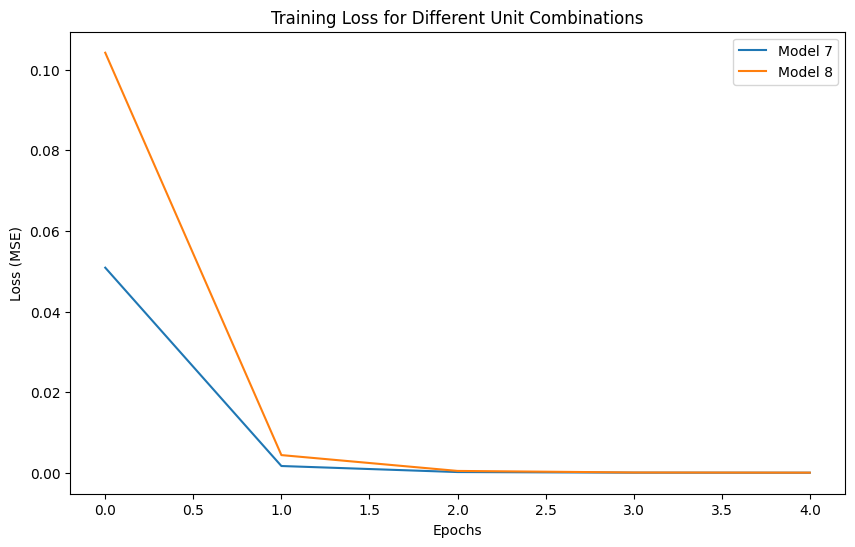

In [52]:
# Plot training loss for each sequence length
plt.figure(figsize=(10, 6))

loss_values_7 = summary_7.history['loss']
loss_values_8 = summary_8.history['loss']

plt.plot(loss_values_7, label=f'Model 7')
plt.plot(loss_values_8, label=f'Model 8')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Different Unit Combinations')
plt.legend()
plt.show()

In [53]:
# Make predictions on the test set

predictions_scaled_7 = model_7.predict(X_test)
predictions_scaled_8 = model_8.predict(X_test)

y_test_actual_7 = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_actual_8 = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


In [54]:
predictions_7 = scaler.inverse_transform(predictions_scaled_7)
predictions_8 = scaler.inverse_transform(predictions_scaled_8)

In [55]:
loss_model_7 = model_7.evaluate(X_test, y_test, verbose=0)
loss_model_8 = model_8.evaluate(X_test, y_test, verbose=0)

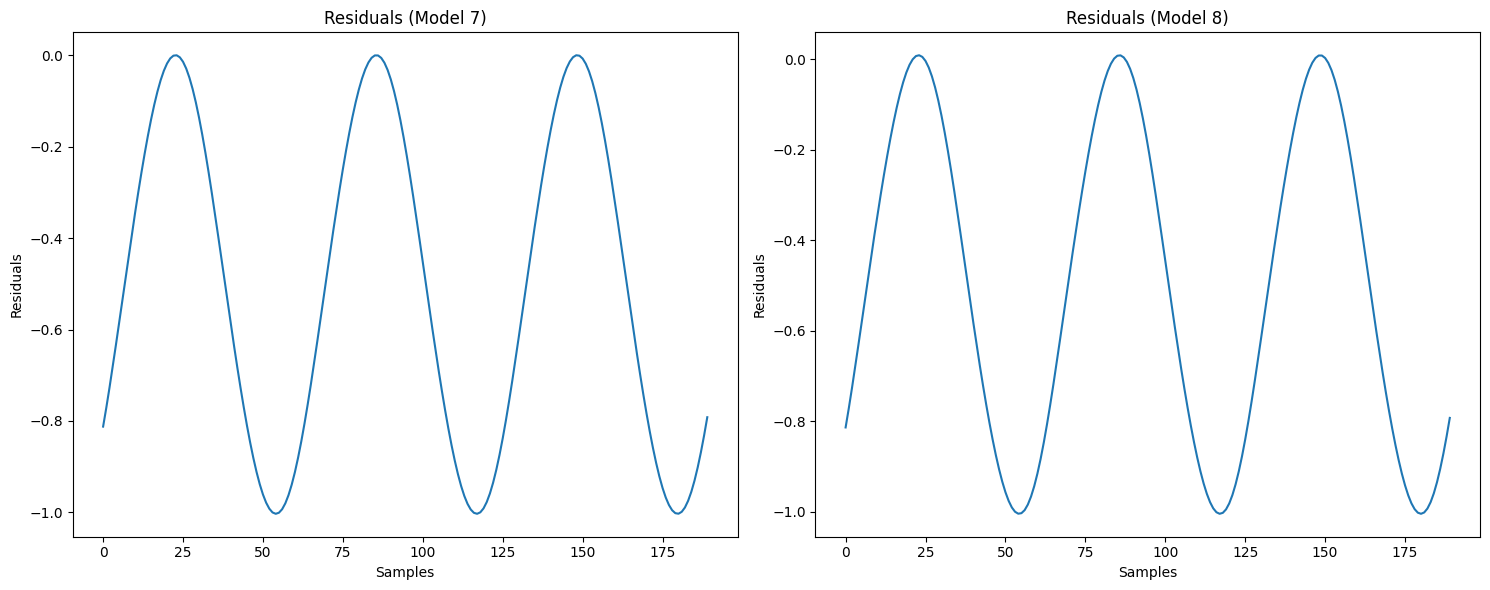

In [56]:
# Calculate residuals for each sequence length

residuals_7 = y_test_actual_7 - predictions_scaled_7
residuals_8 = y_test_actual_8 - predictions_scaled_8

# Create subplots for each sequence length (2 columns, 1 row)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

axes[0].plot(residuals_7)
axes[0].set_title('Residuals (Model 7)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Residuals')

axes[1].plot(residuals_8)
axes[1].set_title('Residuals (Model 8)')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Residuals')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [57]:
mae_model_7 = mean_absolute_error(y_test, model_7.predict(X_test))
mae_model_8 = mean_absolute_error(y_test, model_8.predict(X_test))

r2_model_7 = r2_score(y_test, model_7.predict(X_test))
r2_model_8 = r2_score(y_test, model_8.predict(X_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [58]:
# Create dictionary for model performance metrics

# Create a dictionary with the metrics for each model
metrics_dict = {
    'Model 7': [loss_model_7[0], mae_model_7, r2_model_8, 'unit 1 = 256, unit 2 = 128, unit 3 = 64'],
    'Model 8': [loss_model_8[0], mae_model_8, r2_model_8, 'unit 1 = 128, unit 2 = 64, unit 3 = 32']
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

metrics_df

,Model 7,Model 8
0,0.000012,0.000037
1,0.002939,0.005276
2,0.999702,0.999702
3,"unit 1 = 256, unit 2 = 128, unit 3 = 64","unit 1 = 128, unit 2 = 64, unit 3 = 32"


In [59]:
df_metrics = pd.concat([df_metrics, metrics_df], axis=1)
df_metrics

,Metric,Base Model,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
0,Loss,0.000039,0.000169,0.000059,0.000051,0.000053,0.000002,0.000008,0.000012,0.000037
1,MAE,0.005279,0.010254,0.006747,0.005888,0.005802,0.001144,0.002501,0.002939,0.005276
2,R² Score,0.999684,0.998645,0.999529,0.999609,0.99957,0.999986,0.999933,0.999702,0.999702
3,Description,Base Model,reLu activation function,"Sequence built with, 20, points","Sequence built with, 100, points","Sequence built with, 200, points","unit 1 = 256, unit 2 = 128","unit 1 = 128, unit 2 = 64","unit 1 = 256, unit 2 = 128, unit 3 = 64","unit 1 = 128, unit 2 = 64, unit 3 = 32"


#### Learning rate

In [63]:
learning_rates = [5e-4, 1e-2]
models_learning_rates = {}


for rate in learning_rates:
    model, summary = build_and_train_lstm(X_train, y_train, learning_rate=rate)
    models_learning_rates[rate] = {'model': model, 'summary': summary}
    print(f"Trained model with learning rate = {rate}")

Trained model with learning rate = 0.0005
Trained model with learning rate = 0.01


In [64]:
model_9 = models_learning_rates[rate]['model']
model_10 = models_learning_rates[rate]['model']

summary_9 = models_learning_rates[rate]['summary']
summary_10 = models_learning_rates[rate]['summary']

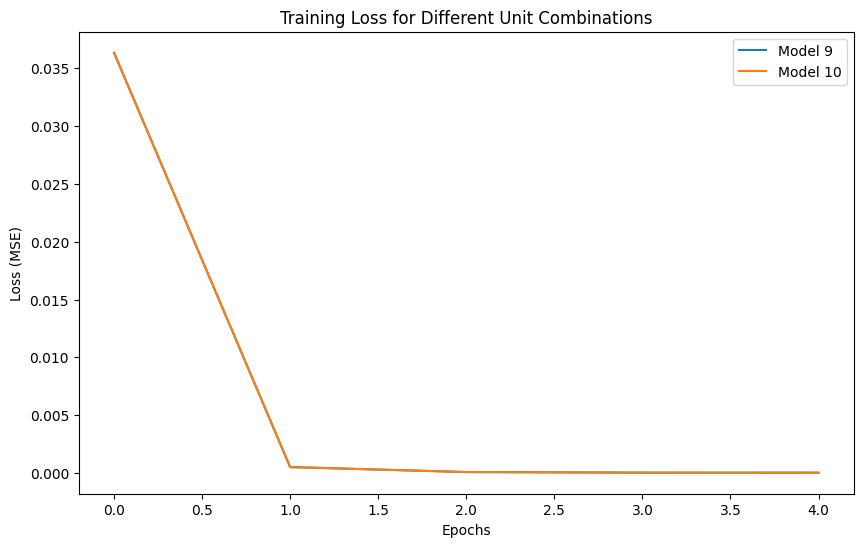

In [67]:
# Plot training loss for each sequence length
plt.figure(figsize=(10, 6))

loss_values_9 = summary_9.history['loss']
loss_values_10 = summary_10.history['loss']

plt.plot(loss_values_9, label=f'Model 9')
plt.plot(loss_values_10, label=f'Model 10')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Different Unit Combinations')
plt.legend()
plt.show()

In [68]:
# Make predictions on the test set

predictions_scaled_9 = model_9.predict(X_test)
predictions_scaled_10 = model_10.predict(X_test)

y_test_actual_9 = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_actual_10 = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [69]:
predictions_9 = scaler.inverse_transform(predictions_scaled_9)
predictions_10 = scaler.inverse_transform(predictions_scaled_10)

In [70]:
loss_model_9 = model_9.evaluate(X_test, y_test, verbose=0)
loss_model_10 = model_10.evaluate(X_test, y_test, verbose=0)

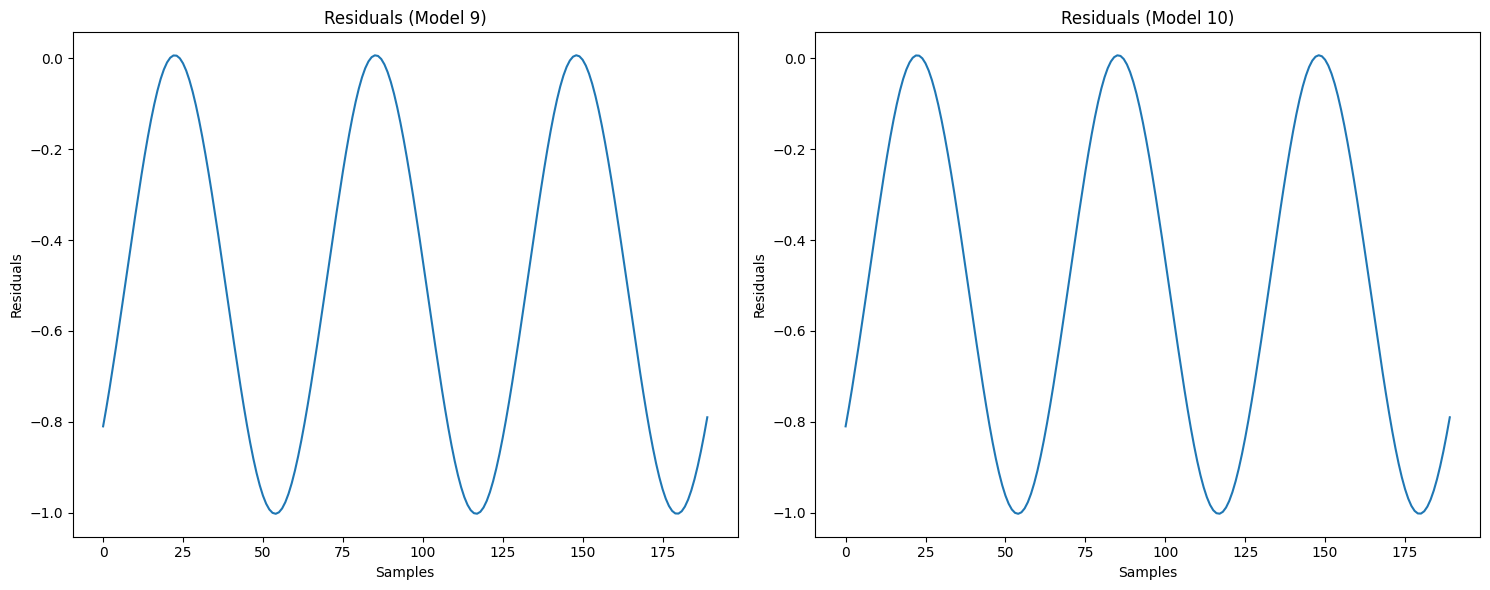

In [71]:
# Calculate residuals for each sequence length

residuals_9 = y_test_actual_9 - predictions_scaled_9
residuals_10 = y_test_actual_10 - predictions_scaled_10

# Create subplots for each sequence length (2 columns, 1 row)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

axes[0].plot(residuals_9)
axes[0].set_title('Residuals (Model 9)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Residuals')

axes[1].plot(residuals_10)
axes[1].set_title('Residuals (Model 10)')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Residuals')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [72]:
mae_model_9 = mean_absolute_error(y_test, model_9.predict(X_test))
mae_model_10 = mean_absolute_error(y_test, model_10.predict(X_test))

r2_model_9 = r2_score(y_test, model_9.predict(X_test))
r2_model_10 = r2_score(y_test, model_10.predict(X_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [79]:
# Create dictionary for model performance metrics

# Create a dictionary with the metrics for each model
metrics_dict = {
    'Model 9': [loss_model_9[0], mae_model_9, r2_model_9, f'learning rate = {learning_rates[0]}'],
    'Model 10': [loss_model_10[0], mae_model_10, r2_model_10, f'learning rate = {learning_rates[1]}']
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

metrics_df

,Model 9,Model 10
0,0.000017,0.000017
1,0.003457,0.003457
2,0.999867,0.999867
3,learning rate = 0.0005,learning rate = 0.01


In [80]:
df_metrics = pd.concat([df_metrics, metrics_df], axis=1)
df_metrics

,Metric,Base Model,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9,Model 10
0,Loss,0.000039,0.000169,0.000059,0.000051,0.000053,0.000002,0.000008,0.000012,0.000037,0.000017,0.000017
1,MAE,0.005279,0.010254,0.006747,0.005888,0.005802,0.001144,0.002501,0.002939,0.005276,0.003457,0.003457
2,R² Score,0.999684,0.998645,0.999529,0.999609,0.99957,0.999986,0.999933,0.999702,0.999702,0.999867,0.999867
3,Description,Base Model,reLu activation function,"Sequence built with, 20, points","Sequence built with, 100, points","Sequence built with, 200, points","unit 1 = 256, unit 2 = 128","unit 1 = 128, unit 2 = 64","unit 1 = 256, unit 2 = 128, unit 3 = 64","unit 1 = 128, unit 2 = 64, unit 3 = 32",learning rate = 0.0005,learning rate = 0.01
